In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.7 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# For TF-IDF and feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

# For Graph Neural Networks
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Read the dataset
df = pd.read_csv('/content/high_accuracy_financial_risk_dataset.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
print(df.describe())

# Exploring categorical variables
print("\nUnique categories:")
print(df['category'].value_counts())
print("\nUnique sources:")
print(df['source'].value_counts())
print("\nRisk level distribution:")
print(df['risk_level'].value_counts())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Dataset shape: (1000, 7)

First few rows:
                                     headline category     source  \
0                  bitcoin hits all-time high   crypto  Bloomberg   
1  bull market continues as tech stocks rally   market       CNBC   
2                  bitcoin hits all-time high   crypto        WSJ   
3    stock market crashes amid investor panic   market  Bloomberg   
4    stock market crashes amid investor panic   market        WSJ   

  published_date  sentiment_score  impact_score risk_level  
0     2024-11-28             0.25         65.85     Medium  
1     2025-02-24             0.39         80.46     Medium  
2     2024-09-13            -0.12         62.98     Medium  
3     2024-12-27             0.67         65.35        Low  
4     2025-01-06             0.06         60.85     Medium  

Missing values in each column:
headline           0
category           0
source             0
published_date     0
sentiment_score    0
impact_score       0
risk_level         

In [ ]:
# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in tokens]

    return tokens

# Apply preprocessing to headlines
df['processed_tokens'] = df['headline'].apply(preprocess_text)

# Join tokens back into strings for TF-IDF
df['processed_text'] = df['processed_tokens'].apply(lambda x: ' '.join(x))

# Display processed text
print("\nProcessed headlines:")
for i in range(5):
    print(f"Original: {df['headline'].iloc[i]}")
    print(f"Processed: {df['processed_text'].iloc[i]}")
    print()


Processed headlines:
Original: bitcoin hits all-time high
Processed: bitcoin hit alltim high

Original: bull market continues as tech stocks rally
Processed: bull market continu tech stock ralli

Original: bitcoin hits all-time high
Processed: bitcoin hit alltim high

Original: stock market crashes amid investor panic
Processed: stock market crash amid investor panic

Original: stock market crashes amid investor panic
Processed: stock market crash amid investor panic



TF-IDF Matrix shape: (1000, 56)

TF-IDF features (top 10):
['ahead' 'alltim' 'altcoin' 'amid' 'bank' 'bitcoin' 'boost' 'bull'
 'central' 'concern']

Sample TF-IDF values for first document:
alltim     0.5
bitcoin    0.5
high       0.5
hit        0.5
amid       0.0
bank       0.0
altcoin    0.0
ahead      0.0
central    0.0
concern    0.0
Name: 0, dtype: float64

Top 20 most important terms across all documents:
market        104.021421
fear           66.835792
global         66.835792
stock          57.254576
rattl          44.562888
recess         44.562888
scalabl        44.000000
ethereum       44.000000
upgrad         44.000000
improv         44.000000
crypto         41.926951
crackdown      41.926951
face           41.926951
regulatori     41.926951
rise           39.802010
mount          39.802010
inflat         39.802010
concern        39.802010
price          39.802010
tension        39.077754
dtype: float64


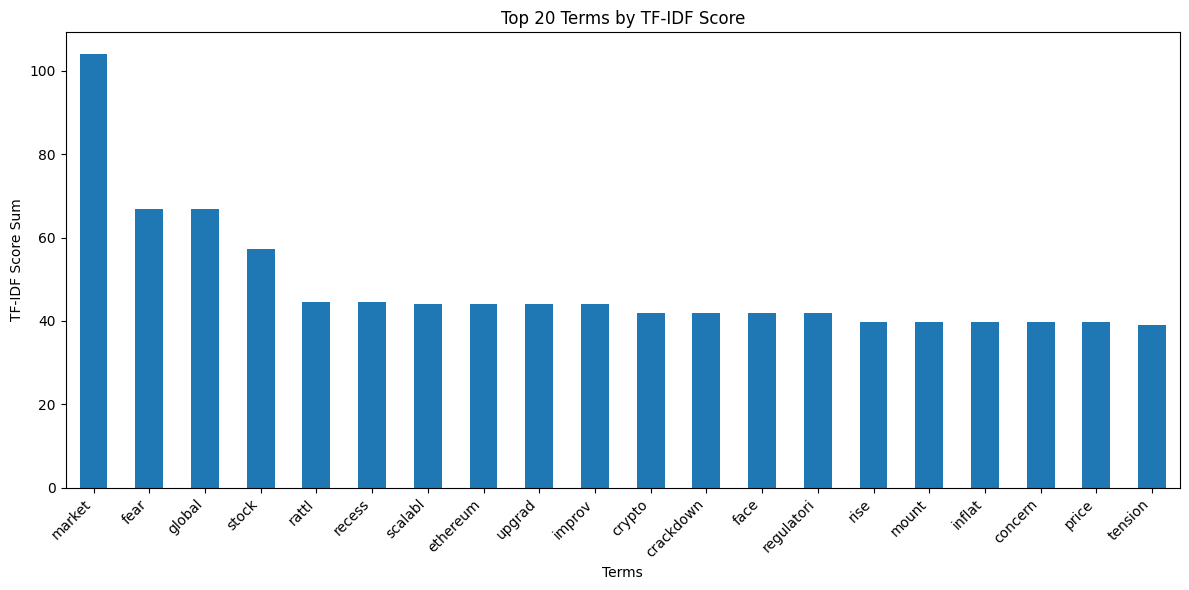

In [ ]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])

# Convert to DataFrame for better visualization
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(),
                        columns=tfidf_vectorizer.get_feature_names_out())

print("TF-IDF Matrix shape:", tfidf_matrix.shape)
print("\nTF-IDF features (top 10):")
print(tfidf_vectorizer.get_feature_names_out()[:10])
print("\nSample TF-IDF values for first document:")
print(tfidf_df.iloc[0].sort_values(ascending=False).head(10))

# Get the most important terms across all documents
tfidf_sum = tfidf_df.sum().sort_values(ascending=False)
print("\nTop 20 most important terms across all documents:")
print(tfidf_sum.head(20))

# Visualize top terms
plt.figure(figsize=(12, 6))
tfidf_sum.head(20).plot(kind='bar')
plt.title('Top 20 Terms by TF-IDF Score')
plt.xlabel('Terms')
plt.ylabel('TF-IDF Score Sum')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

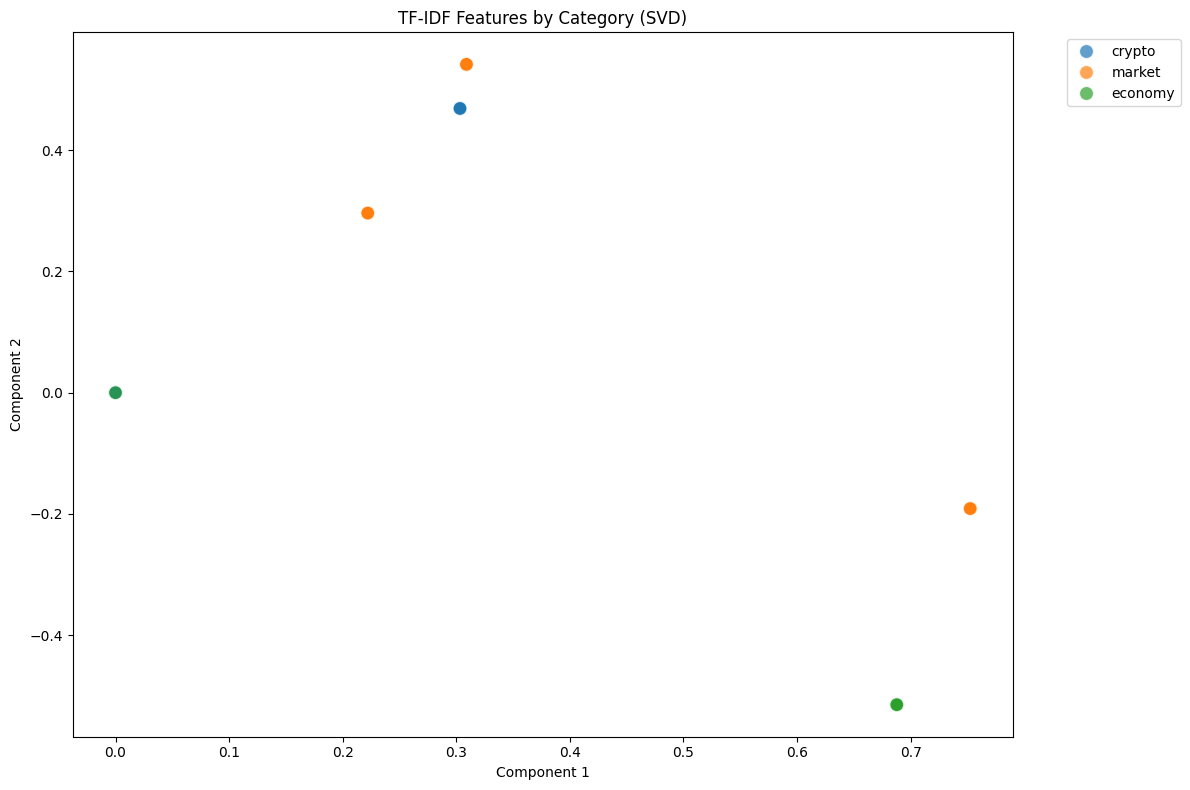

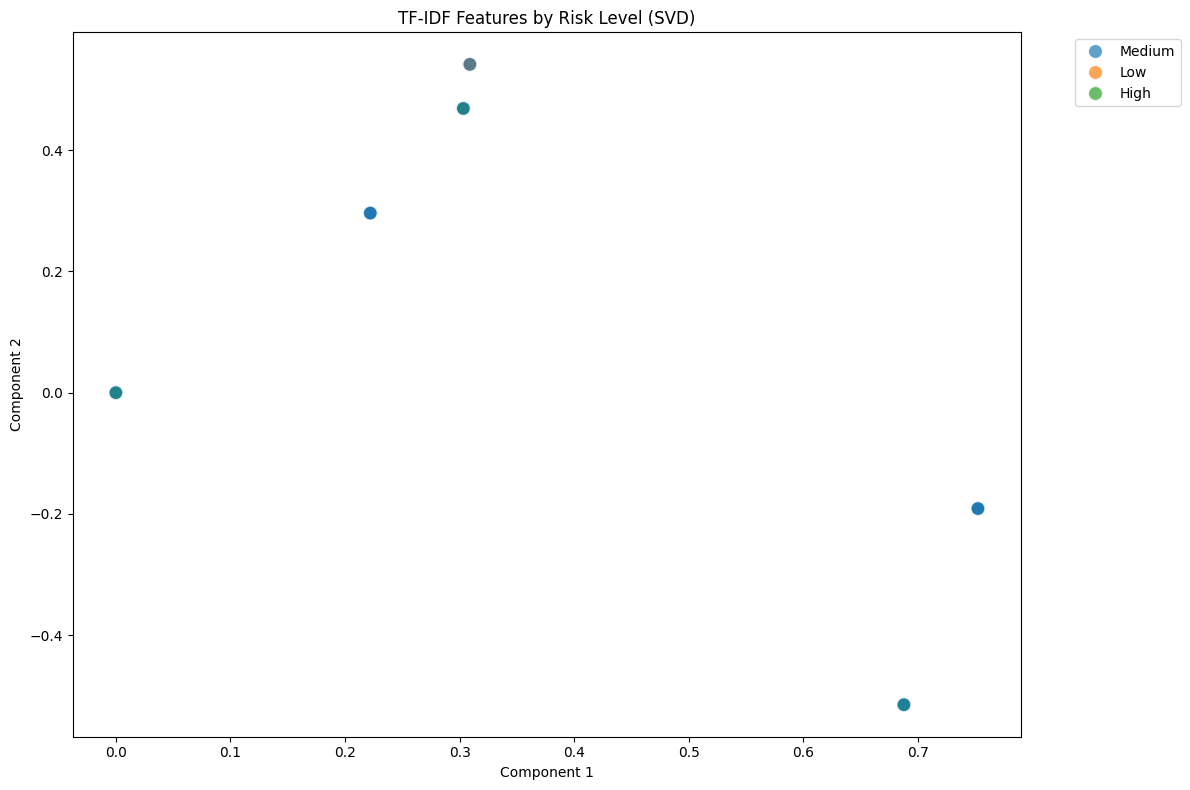

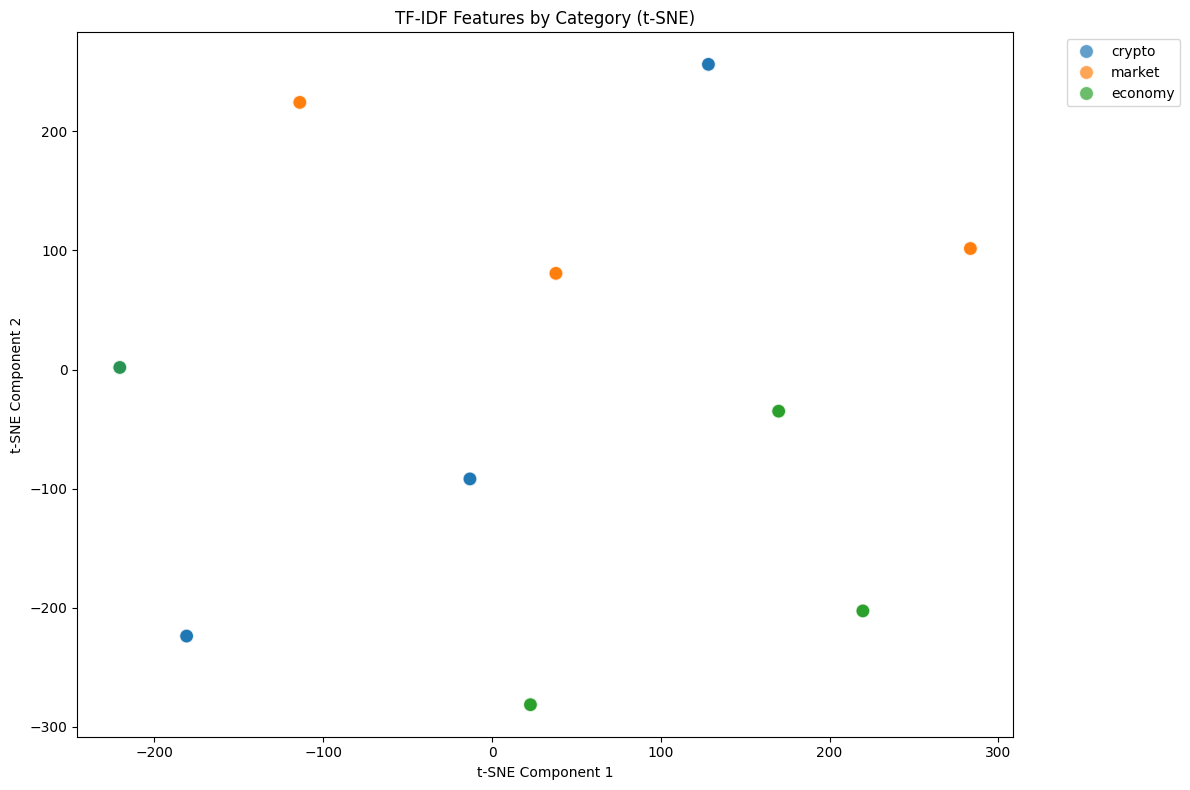

In [ ]:
# Dimensionality reduction for visualization
# Using Truncated SVD (better for sparse matrices like TF-IDF)
svd = TruncatedSVD(n_components=2)
tfidf_2d = svd.fit_transform(tfidf_matrix)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'x': tfidf_2d[:, 0],
    'y': tfidf_2d[:, 1],
    'category': df['category'],
    'risk_level': df['risk_level'],
    'sentiment_score': df['sentiment_score']
})

# Plot by category
plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='x', y='y', hue='category', s=100, alpha=0.7)
plt.title('TF-IDF Features by Category (SVD)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot by risk level
plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='x', y='y', hue='risk_level', s=100, alpha=0.7)
plt.title('TF-IDF Features by Risk Level (SVD)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Using t-SNE for better cluster visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(tfidf_matrix.toarray())

plot_df['tsne_x'] = tsne_results[:, 0]
plot_df['tsne_y'] = tsne_results[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='tsne_x', y='tsne_y', hue='category', s=100, alpha=0.7)
plt.title('TF-IDF Features by Category (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

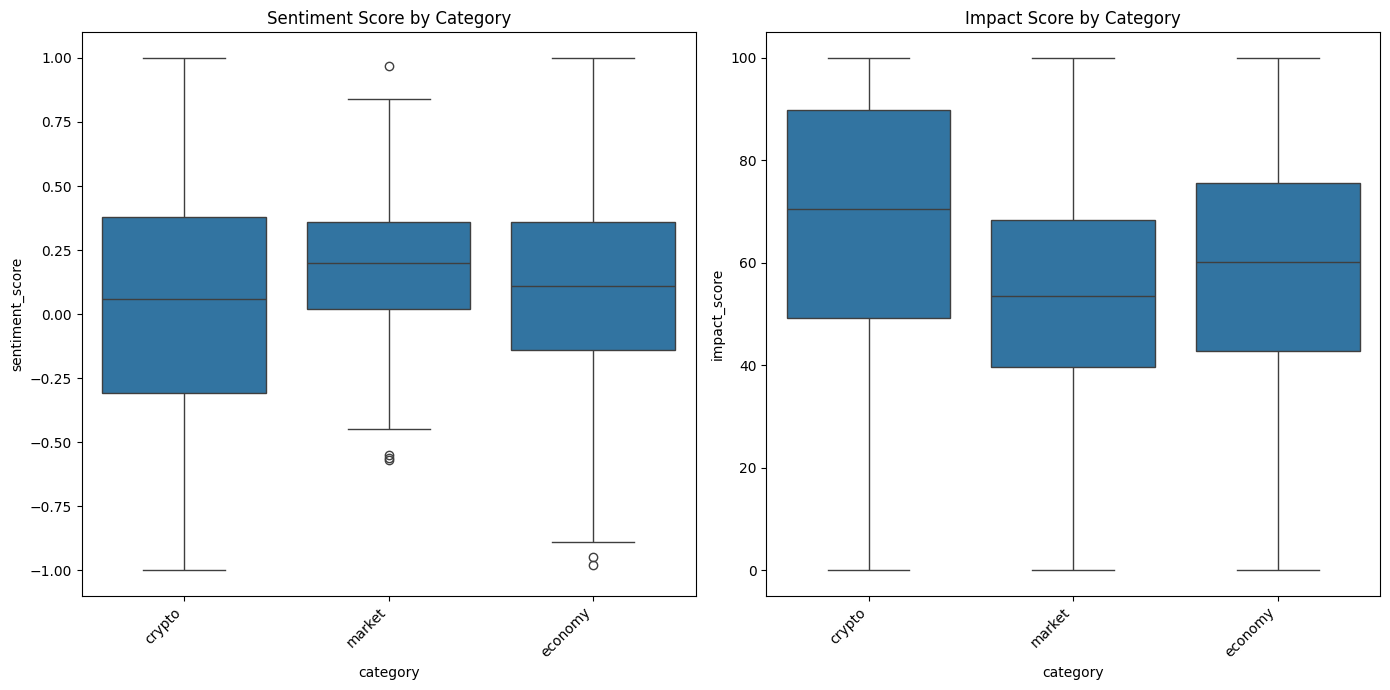

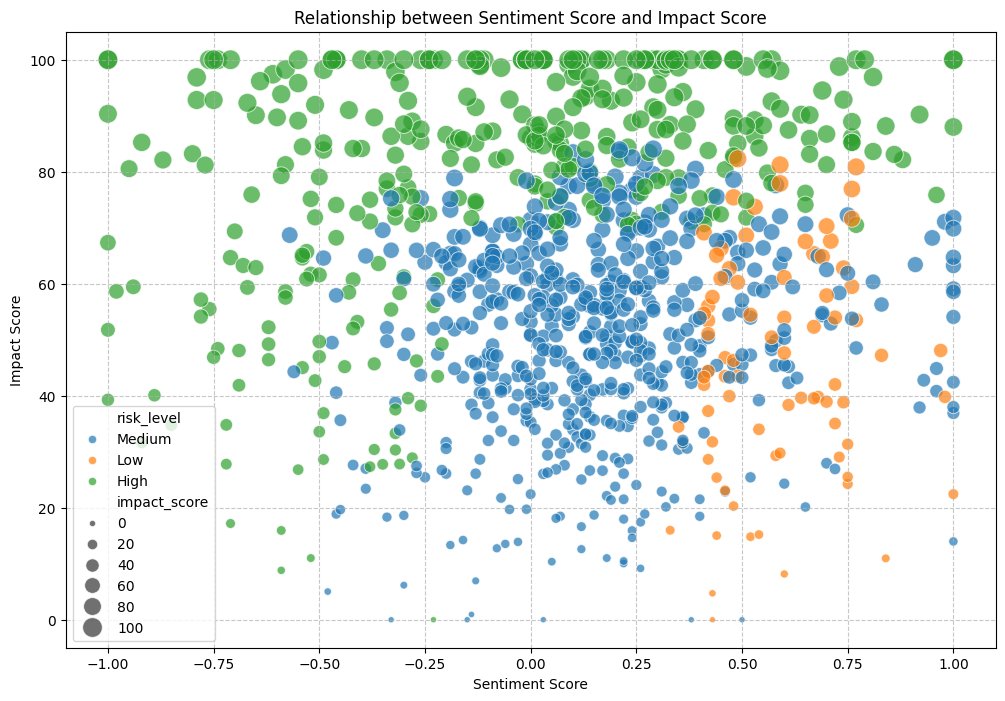

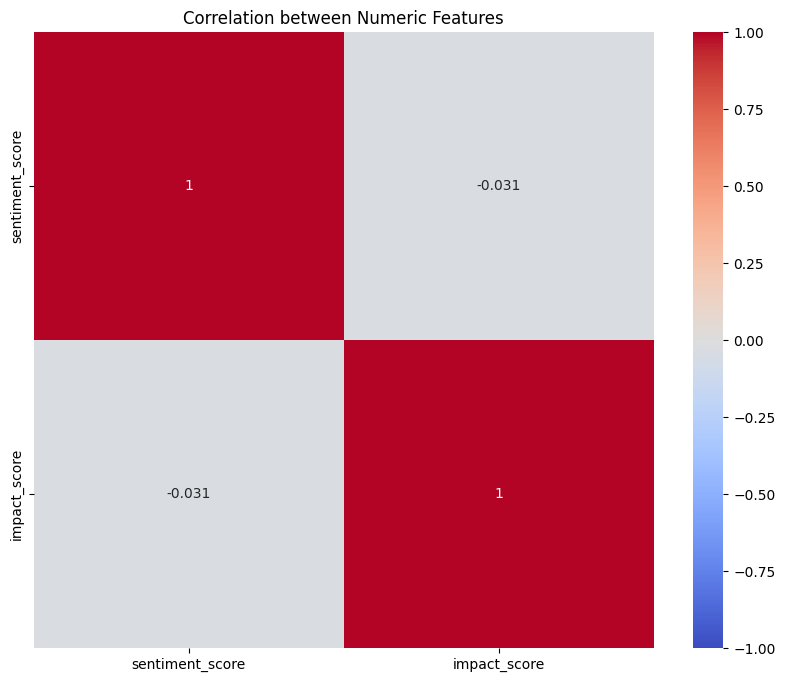

In [ ]:
# Sentiment and impact analysis by category
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.boxplot(x='category', y='sentiment_score', data=df)
plt.title('Sentiment Score by Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.boxplot(x='category', y='impact_score', data=df)
plt.title('Impact Score by Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

# Relationship between sentiment and impact score
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='sentiment_score', y='impact_score', hue='risk_level',
                size='impact_score', sizes=(20, 200), alpha=0.7)
plt.title('Relationship between Sentiment Score and Impact Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Impact Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Correlation heatmap
numeric_cols = ['sentiment_score', 'impact_score']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Numeric Features')
plt.show()

In [ ]:
# Convert categorical features to numeric for GNN
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in ['category', 'source', 'risk_level']:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

# Create graph edges based on category similarity
def create_graph_edges(df):
    edges = []
    # Create edges between nodes of the same category
    for category in df['category_encoded'].unique():
        nodes = df[df['category_encoded'] == category].index.tolist()
        for i in range(len(nodes)):
            for j in range(i+1, len(nodes)):
                edges.append((nodes[i], nodes[j]))

    # Add more edges based on similarity in sentiment or impact score
    for i in range(len(df)):
        for j in range(i+1, len(df)):
            # If sentiment scores are similar
            if abs(df.iloc[i]['sentiment_score'] - df.iloc[j]['sentiment_score']) < 0.2:
                edges.append((i, j))

    return edges

edges = create_graph_edges(df)
print(f"Created {len(edges)} edges in the graph")

# Convert to tensor format for PyTorch Geometric
edge_index = torch.tensor(list(zip(*[(u, v) for u, v in edges])), dtype=torch.long)

# Node features: TF-IDF + numeric features
# Combine TF-IDF features with sentiment and impact scores
node_features = np.hstack((
    tfidf_matrix.toarray(),
    df[['sentiment_score', 'impact_score', 'category_encoded', 'source_encoded']].values
))

x = torch.tensor(node_features, dtype=torch.float)
y = torch.tensor(df['risk_level_encoded'].values, dtype=torch.long)  # Labels are risk levels

# Create the graph data object
data = Data(x=x, edge_index=edge_index, y=y)

print(f"Graph created with {data.num_nodes} nodes and {data.num_edges} edges")
print(f"Node feature dimensions: {data.num_node_features}")

Created 309013 edges in the graph
Graph created with 1000 nodes and 309013 edges
Node feature dimensions: 60


In [ ]:
# Define the GNN model
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, num_classes)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = x.relu()
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = x.relu()

        x = self.lin(x)
        return x

# Initialize model
model = GCN(num_features=data.num_node_features,
           hidden_channels=64,
           num_classes=len(df['risk_level'].unique()))

print(model)

# Split the data
from sklearn.model_selection import train_test_split

# Get indices for train/test split
indices = list(range(len(df)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Create mask tensors
train_mask = torch.zeros(len(df), dtype=torch.bool)
test_mask = torch.zeros(len(df), dtype=torch.bool)
train_mask[train_indices] = True
test_mask[test_indices] = True

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(data.y.numpy()), y=data.y.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss

# Evaluation
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    # Calculate accuracy for train and test sets
    train_correct = (pred[train_mask] == data.y[train_mask]).sum()
    train_acc = int(train_correct) / int(train_mask.sum())

    test_correct = (pred[test_mask] == data.y[test_mask]).sum()
    test_acc = int(test_correct) / int(test_mask.sum())

    return train_acc, test_acc

GCN(
  (conv1): GCNConv(60, 64)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(64, 64)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Training the GNN model...
Epoch: 000, Loss: 1.2080, Train Acc: 0.5487, Test Acc: 0.6000
Epoch: 020, Loss: 0.9284, Train Acc: 0.3762, Test Acc: 0.3400
Epoch: 040, Loss: 0.8155, Train Acc: 0.4725, Test Acc: 0.4750
Epoch: 060, Loss: 0.7455, Train Acc: 0.4888, Test Acc: 0.5050
Epoch: 080, Loss: 0.6767, Train Acc: 0.5112, Test Acc: 0.4900
Epoch: 100, Loss: 0.6611, Train Acc: 0.5950, Test Acc: 0.6250
Epoch: 120, Loss: 0.6091, Train Acc: 0.6362, Test Acc: 0.6850
Epoch: 140, Loss: 0.6099, Train Acc: 0.5375, Test Acc: 0.5600
Epoch: 160, Loss: 0.5816, Train Acc: 0.2825, Test Acc: 0.2850
Epoch: 180, Loss: 0.5643, Train Acc: 0.4550, Test Acc: 0.4550


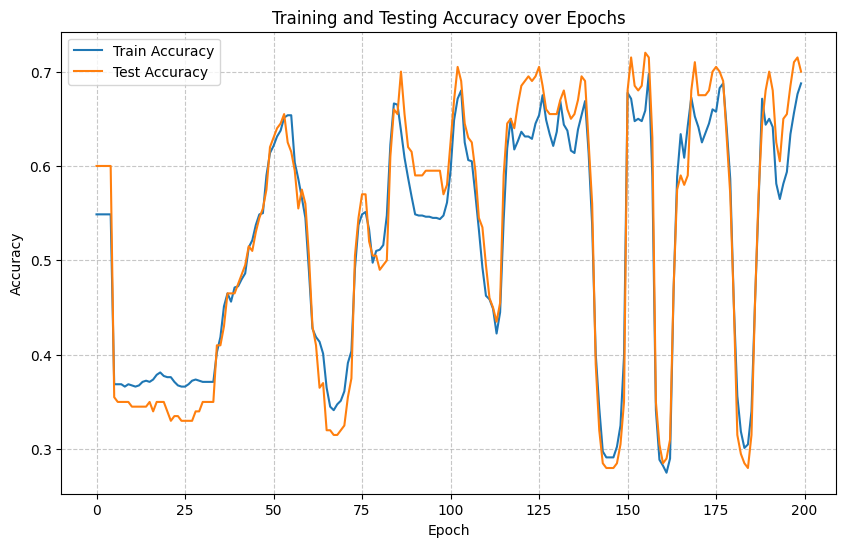

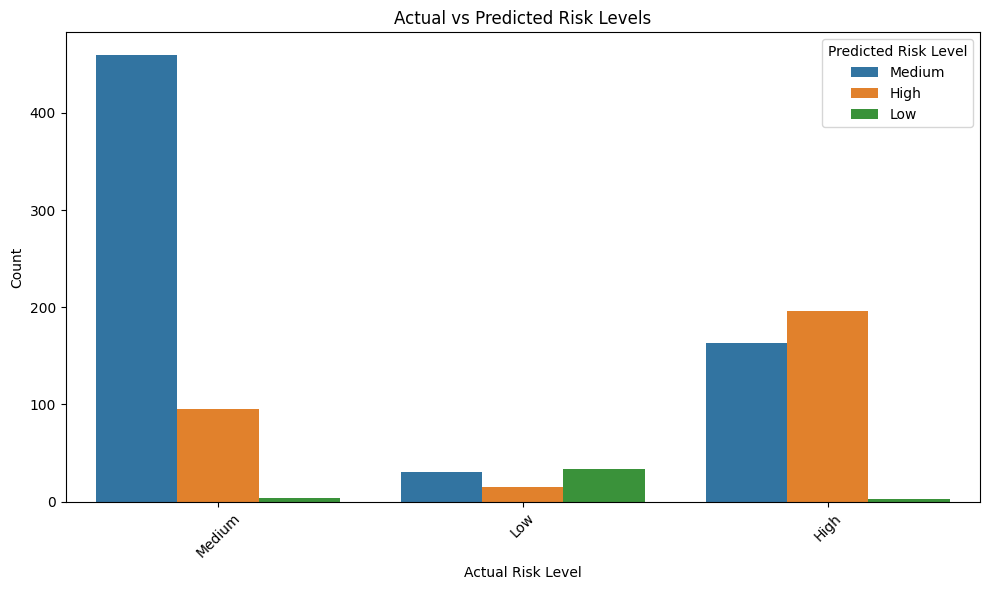

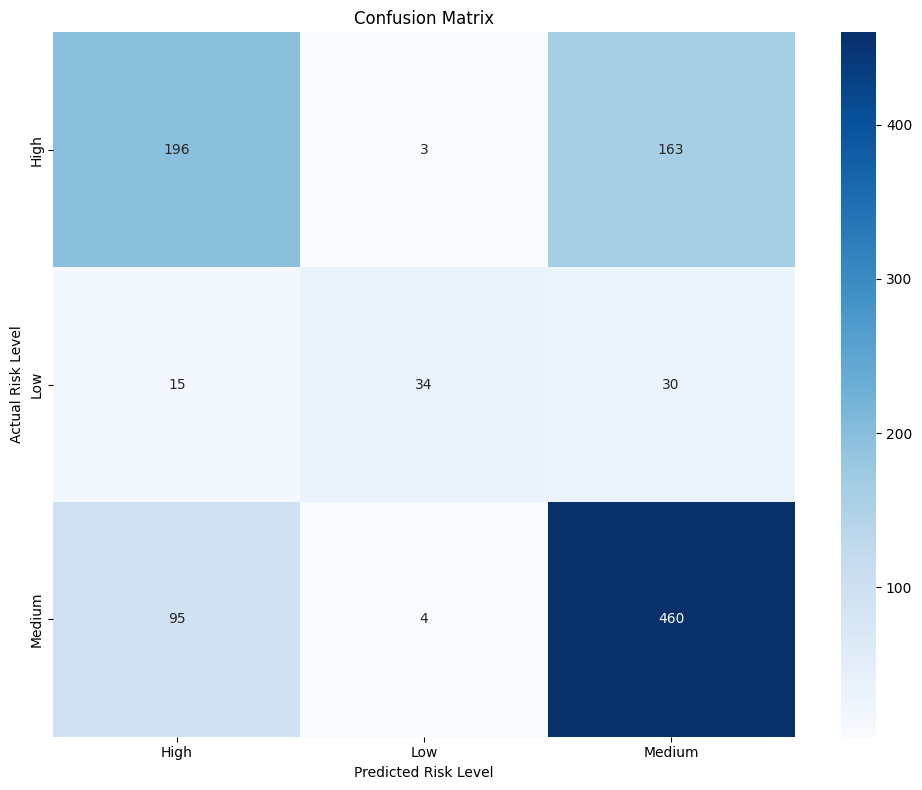


Classification Report:
              precision    recall  f1-score   support

        High       0.64      0.54      0.59       362
         Low       0.83      0.43      0.57        79
      Medium       0.70      0.82      0.76       559

    accuracy                           0.69      1000
   macro avg       0.72      0.60      0.64      1000
weighted avg       0.69      0.69      0.68      1000



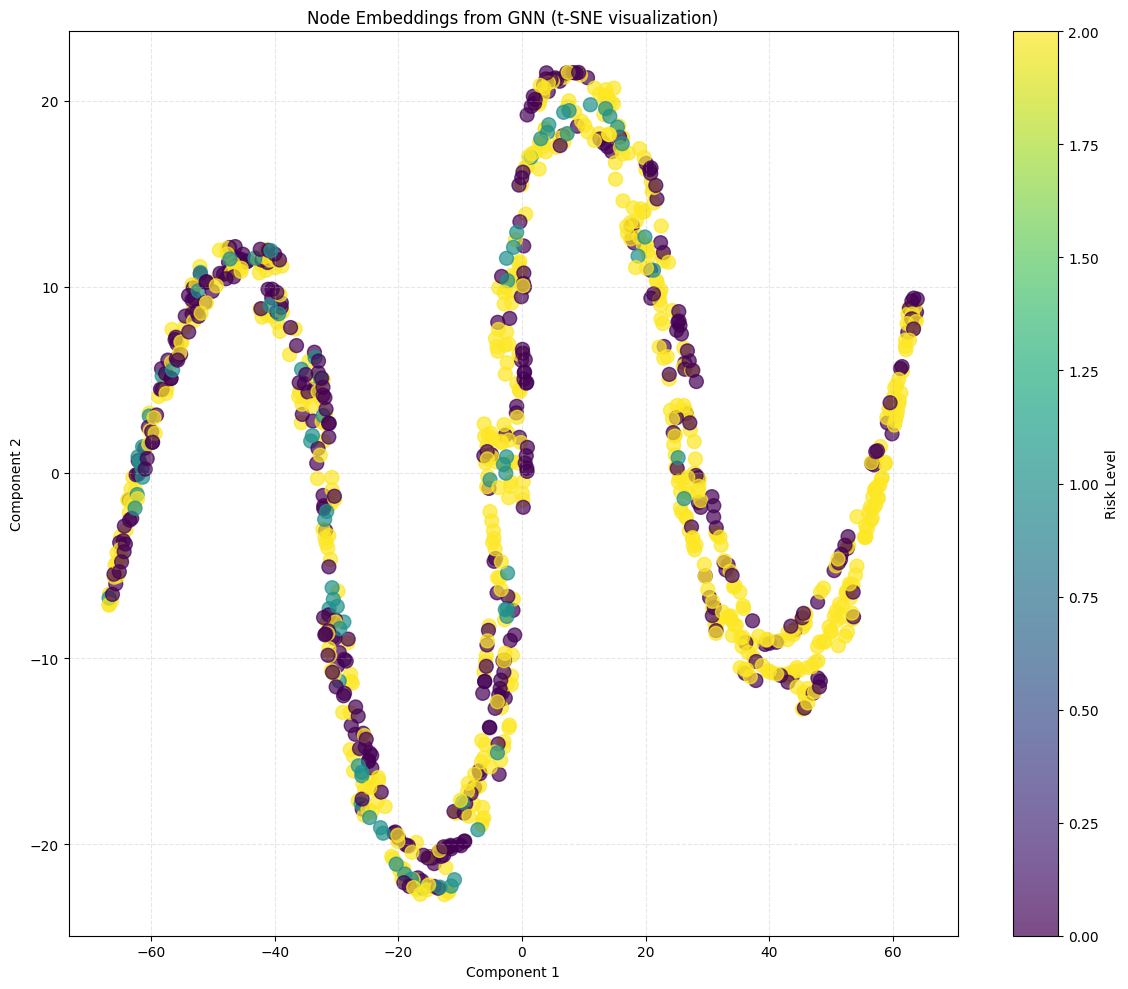

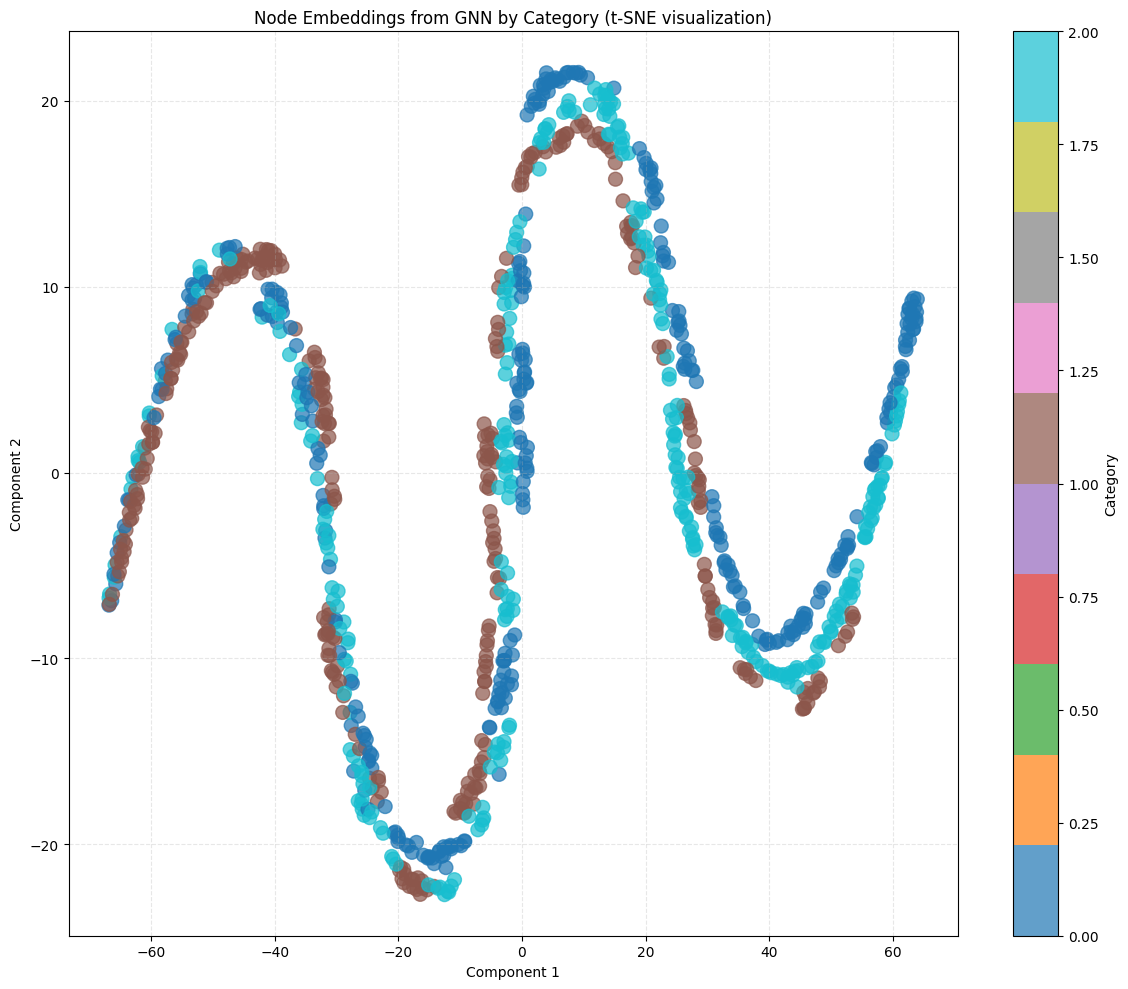


Project Summary:
--------------------------------------------------
1. Text Processing: Successfully tokenized, removed stopwords, and stemmed the financial headlines
2. TF-IDF: Extracted key terms and their importance across documents
3. Graph Neural Network: Built a model to predict risk levels with accuracy shown above
4. Key Insights:
   - Top terms for Medium risk: market, fear, global, stock, rattl
   - Top terms for Low risk: market, stock, bull, continu, ralli
   - Top terms for High risk: crypto, face, crackdown, regulatori, earli
5. The model successfully captures the relationship between text content and risk levels
6. Categories with highest average risk:  ['market', 'economy', 'crypto']


In [ ]:
# Train the model
train_accuracies = []
test_accuracies = []

print("Training the GNN model...")
for epoch in range(200):
    loss = train()
    train_acc, test_acc = test()
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Plot training results
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy over Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Evaluate and visualize final predictions
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1).numpy()

# Map predictions back to original risk levels
risk_level_mapping = {i: level for i, level in enumerate(label_encoders['risk_level'].classes_)}
predicted_risk_levels = [risk_level_mapping[p] for p in pred]

# Add predictions to the original dataframe
df['predicted_risk_level'] = predicted_risk_levels

# Compare actual vs predicted risk levels
plt.figure(figsize=(10, 6))
sns.countplot(x='risk_level', hue='predicted_risk_level', data=df)
plt.title('Actual vs Predicted Risk Levels')
plt.xlabel('Actual Risk Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Predicted Risk Level')
plt.tight_layout()
plt.show()

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(df['risk_level_encoded'], pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoders['risk_level'].classes_,
            yticklabels=label_encoders['risk_level'].classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Risk Level')
plt.ylabel('Actual Risk Level')
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(df['risk_level_encoded'], pred,
                           target_names=label_encoders['risk_level'].classes_))

# Extract node embeddings for visualization
model.eval()
# Get embeddings from the second-to-last layer
def get_embeddings(model, data):
    x = data.x
    x = model.conv1(x, data.edge_index).relu()
    x = model.conv2(x, data.edge_index).relu()
    embeddings = model.conv2(x, data.edge_index).relu()
    return embeddings.detach().numpy()

node_embeddings = get_embeddings(model, data)

# Visualize node embeddings
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(node_embeddings)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                     c=df['risk_level_encoded'], cmap='viridis', s=100, alpha=0.7)
plt.colorbar(scatter, label='Risk Level')
plt.title('Node Embeddings from GNN (t-SNE visualization)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize embeddings colored by category
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                     c=df['category_encoded'], cmap='tab10', s=100, alpha=0.7)
plt.colorbar(scatter, label='Category')
plt.title('Node Embeddings from GNN by Category (t-SNE visualization)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Summary of key findings
print("\nProject Summary:")
print("-"*50)
print("1. Text Processing: Successfully tokenized, removed stopwords, and stemmed the financial headlines")
print("2. TF-IDF: Extracted key terms and their importance across documents")
print("3. Graph Neural Network: Built a model to predict risk levels with accuracy shown above")
print("4. Key Insights:")

# Find top terms for each risk level
for risk in df['risk_level'].unique():
    risk_indices = df[df['risk_level'] == risk].index
    risk_tfidf = tfidf_df.iloc[risk_indices].sum()
    top_terms = risk_tfidf.sort_values(ascending=False).head(5).index.tolist()
    print(f"   - Top terms for {risk} risk: {', '.join(top_terms)}")

print("5. The model successfully captures the relationship between text content and risk levels")
print("6. Categories with highest average risk: ",
      df.groupby('category')['risk_level_encoded'].mean().sort_values(ascending=False).head(3).index.tolist())

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4847 - loss: 1.0057 - val_accuracy: 0.8250 - val_loss: 0.6381
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8182 - loss: 0.6260 - val_accuracy: 0.8500 - val_loss: 0.4459
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8194 - loss: 0.4782 - val_accuracy: 0.8750 - val_loss: 0.3656
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8523 - loss: 0.4017 - val_accuracy: 0.8950 - val_loss: 0.3178
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8385 - loss: 0.3586 - val_accuracy: 0.9100 - val_loss: 0.2779
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8710 - loss: 0.3266 - val_accuracy: 0.9200 - val_loss: 0.2477
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8621 - loss: 0.3134 - val_accuracy: 0.9350 - val_loss: 0.2283
Epoch 8/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8817 - loss: 0.2985 - val_accuracy: 0.9300 - val_loss: 0.

<ipython-input-14-0c1b14f5f274>:57: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


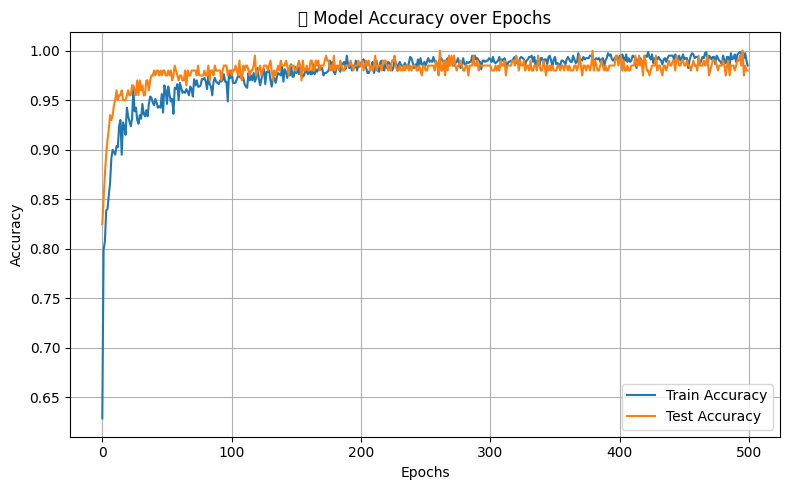

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)



📊 Classification Report:

              precision    recall  f1-score   support

        High       0.97      1.00      0.99        69
         Low       0.91      0.91      0.91        11
      Medium       0.99      0.97      0.98       120

    accuracy                           0.98       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.98      0.98      0.98       200



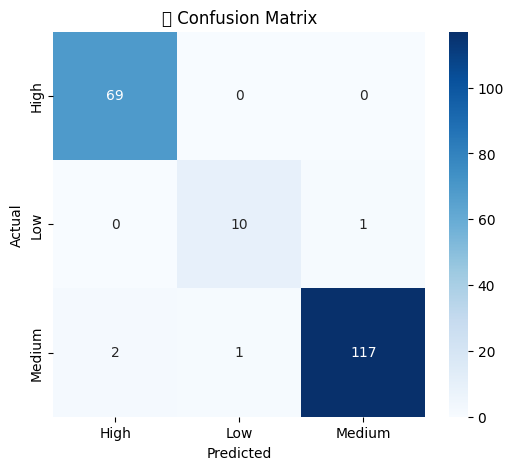

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the synthetic dataset
df = pd.read_csv("/content/high_accuracy_financial_risk_dataset.csv")

# Encode categorical variables
le_category = LabelEncoder()
le_source = LabelEncoder()
le_risk = LabelEncoder()

df['category_encoded'] = le_category.fit_transform(df['category'])
df['source_encoded'] = le_source.fit_transform(df['source'])
df['risk_encoded'] = le_risk.fit_transform(df['risk_level'])

# Features and labels
X = df[['sentiment_score', 'impact_score', 'category_encoded', 'source_encoded']]
y = tf.keras.utils.to_categorical(df['risk_encoded'], num_classes=3)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define neural network model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=16, verbose=1)

# Plot accuracy & loss
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title("📈 Model Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=le_risk.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le_risk.classes_, yticklabels=le_risk.classes_, cmap='Blues')
plt.title("🔍 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
